<a href="https://colab.research.google.com/github/aalexakos/thesis-smart-grids/blob/main/helios_thesis_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## imports and config
import os, time
# import boto3
import pandas as pd
import time
 
import pytz
from matplotlib import pyplot as plt    


pd.set_option('display.float_format', lambda x: '%.3f' % x)

# park coordinates
coordinates = {'latitude': 39.102583, 'longitude': 21.042528, 'name': 'Arta-1', 'altitude': 18, 'timezone': 'Europe/Athens'}

from google.colab import drive
drive.mount('/content/drive/')

# total_data csv location
input_file = '/content/drive/MyDrive/alexakos-thesis/datasets/monthly_data.csv'

effective_irradiance_column_name = 'climacell'

Mounted at /content/drive/


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
total_df = pd.read_csv(input_file)
total_df['datetime'] = pd.to_datetime(total_df['datetime'], errors='coerce')

total_df

,datetime,sensor_avg,active_power,openweathermap,timestamp,dni,dhi,climacell,temp_air,windSpeed,weatherCode,pySolar,altidute,p_solar_horizontal,horizontal_avg,openweather_modular,climacell_modular,modular_avg
0,2021-06-01 03:00:00,23.467,65.812,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan
1,2021-06-01 04:00:00,69.214,272.940,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,nan
2,2021-06-01 05:00:00,259.855,1089.745,173.510,1622523600.000,531.660,52.970,130.540,15.400,1.380,1101.000,584.774,18.693,553.928,152.025,367.385,276.402,321.894
3,2021-06-01 06:00:00,492.937,2091.360,368.240,1622527200.000,708.140,76.030,307.790,17.400,0.780,1101.000,734.007,30.147,634.723,338.015,574.313,480.034,527.173
4,2021-06-01 07:00:00,695.443,2893.392,564.290,1622530800.000,802.750,93.080,523.310,18.760,1.270,1100.000,810.078,41.767,604.209,543.800,711.324,659.666,685.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,2021-06-30 12:00:00,686.347,2792.367,983.120,1625054400.000,885.140,147.340,932.050,38.400,5.500,1000.000,864.640,66.622,343.080,957.585,845.152,801.249,823.201
706,2021-06-30 13:00:00,557.772,2335.633,905.950,1625058000.000,859.370,149.510,847.440,36.200,3.780,1001.000,844.495,56.262,469.032,876.695,911.892,852.998,882.445
707,2021-06-30 14:00:00,332.618,1419.207,778.060,1625061600.000,855.210,116.870,694.830,34.510,3.150,1000.000,807.505,44.872,572.267,736.445,932.807,833.024,882.916
708,2021-06-30 15:00:00,186.103,781.467,611.070,1625065200.000,811.430,99.630,556.070,33.260,2.320,1000.000,741.934,33.254,620.441,583.570,895.340,814.754,855.047


In [3]:
p_mp_csv = '/content/drive/MyDrive/alexakos-thesis/datasets/monthly_p_mp.csv'
p_mp = pd.read_csv(p_mp_csv)
p_mp['datetime'] = pd.to_datetime(p_mp['datetime'], errors='coerce')

total_df=total_df.merge(p_mp, how='inner', on = 'datetime')

In [4]:
total_df['hour']=total_df.datetime.dt.hour

In [5]:
sampling_times = total_df[['datetime']].copy()
sampling_times

,datetime
0,2021-06-01 05:00:00
1,2021-06-01 06:00:00
2,2021-06-01 07:00:00
3,2021-06-01 08:00:00
4,2021-06-01 09:00:00
...,...
679,2021-06-30 12:00:00
680,2021-06-30 13:00:00
681,2021-06-30 14:00:00
682,2021-06-30 15:00:00


In [6]:
# Number of panels / string 24
# Nominal power of PV panel [kWp] 0.24

# Number of strings / Module / Inverter Inverter 1 Inverter 2 Inverter 3 Inverter 4
# Module 1	62	62	62	61	
# Module 2	62	62	62	61	
# Module 3	62	62	62	62	
# Module 4	62	62	62	n.a.	
# Strings / Inverter	248	248	248	184	
# Total number of strings	928				
# Total number of PV panels	22,272				
# Installed power of PV station [kWp]	5,345				

# *A series-connected set of solar cells or modules is called a "string"
!pip install pvlib
import pvlib
from pvlib.pvsystem import PVSystem
import pvlib.pvsystem as pvsystem
from pvlib.location import Location
from pvlib.modelchain import ModelChain

INVERTER_1400 = "Power-One: ULTRA-1500-TL-OUTD-2-US-690-x-y-z [690V]".replace(" ", "_")
INVERTER_1400 = ''.join([c if (c.isalpha() or c.isnumeric()) else "_" for c in INVERTER_1400])

INVERTER_1050 = "Power-One: ULTRA-1100-TL-OUTD-2-US-690-x-y-z [690V]".replace(" ", "_")
INVERTER_1050 = ''.join([c if (c.isalpha() or c.isnumeric()) else "_" for c in INVERTER_1050])
print(INVERTER_1400)
print(INVERTER_1050)

MODULE = "Phono Solar Technology Co._Ltd. PS240M-20/U".replace(" ", "_")
MODULE = ''.join([c if (c.isalpha() or c.isnumeric()) else "_" for c in MODULE])
print(MODULE)


def get_system(m_modules_per_string, m_strings_per_inverter, inverter_name):
    sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
    sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
    cec_modules = pvlib.pvsystem.retrieve_sam('CECMod')
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

    module = cec_modules[MODULE]
    inverter = cec_inverters[inverter_name]
    temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['pvsyst']['freestanding']

    return PVSystem(module=module.name, module_parameters=module,
                    inverter_parameters=inverter, inverter=inverter.name,
                    surface_azimuth=surface_azimuth, surface_tilt=surface_tilt,
                    modules_per_string=m_modules_per_string, strings_per_inverter=m_strings_per_inverter,
                    temperature_model_parameters=temperature_model_parameters)


modules_per_string = 24  # was 62
strings_per_inverter = 248 * 3 + 184  # 232 # was 15
surface_azimuth = 180  # surface_azimuth (float or array-like, default 180) – Azimuth angle of the module surface. North=0, East=90, South=180, West=270.
surface_tilt = 25  # surface_tilt (float or array-like, default 0) – Surface tilt angles in decimal degrees. The tilt angle is defined as degrees from horizontal (e.g. surface facing up = 0, surface facing horizon = 90)

location = Location(coordinates['latitude'], coordinates['longitude'], name=coordinates['name'], altitude=coordinates['altitude'],
                    tz=coordinates['timezone'])

system = get_system(modules_per_string, strings_per_inverter, INVERTER_1400)

mc = ModelChain(system, location, aoi_model="no_loss")
mc

     |████████████████████████████████| 27.5 MB 110 kB/s 
Power_One__ULTRA_1500_TL_OUTD_2_US_690_x_y_z__690V_
Power_One__ULTRA_1100_TL_OUTD_2_US_690_x_y_z__690V_
Phono_Solar_Technology_Co__Ltd__PS240M_20_U


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: pvsyst_temp
  losses_model: no_extra_losses

In [7]:
irradiance_df = total_df[['datetime', effective_irradiance_column_name]]
effective_irradiance_df = irradiance_df.set_index(['datetime'])
effective_irradiance_df = effective_irradiance_df.rename(columns={effective_irradiance_column_name: 'effective_irradiance'})
effective_irradiance_df

,effective_irradiance
datetime,
2021-06-01 05:00:00,130.540
2021-06-01 06:00:00,307.790
2021-06-01 07:00:00,523.310
2021-06-01 08:00:00,710.120
2021-06-01 09:00:00,799.270
...,...
2021-06-30 12:00:00,932.050
2021-06-30 13:00:00,847.440
2021-06-30 14:00:00,694.830


In [8]:
mc.run_model_from_effective_irradiance(effective_irradiance_df)
df_for = mc.results.dc['p_mp'].to_frame()
df_for['p_mp'] = df_for['p_mp'] / 1000
df_forecasted = df_for.rename(columns={'p_mp': 'p_mp_from_effective'})
df_forecasted

,p_mp_from_effective
datetime,
2021-06-01 05:00:00,694.887
2021-06-01 06:00:00,1642.146
2021-06-01 07:00:00,2730.444
2021-06-01 08:00:00,3604.646
2021-06-01 09:00:00,3997.659
...,...
2021-06-30 12:00:00,4553.179
2021-06-30 13:00:00,4203.349
2021-06-30 14:00:00,3535.648


In [9]:
total_df = total_df.set_index('datetime')

In [10]:
merged_total_df = total_df.join(df_forecasted)
merged_total_df

,sensor_avg,active_power,openweathermap,timestamp,dni,dhi,climacell,temp_air,windSpeed,weatherCode,pySolar,altidute,p_solar_horizontal,horizontal_avg,openweather_modular,climacell_modular,modular_avg,startTime,p_mp,hour,p_mp_from_effective
datetime,,,,,,,,,,,,,,,,,,,,,
2021-06-01 05:00:00,259.855,1089.745,173.510,1622523600.000,531.660,52.970,130.540,15.400,1.380,1101.000,584.774,18.693,553.928,152.025,367.385,276.402,321.894,2021-06-01 05:00:00+00:00,809.314,5,694.887
2021-06-01 06:00:00,492.937,2091.360,368.240,1622527200.000,708.140,76.030,307.790,17.400,0.780,1101.000,734.007,30.147,634.723,338.015,574.313,480.034,527.173,2021-06-01 06:00:00+00:00,1962.195,6,1642.146
2021-06-01 07:00:00,695.443,2893.392,564.290,1622530800.000,802.750,93.080,523.310,18.760,1.270,1100.000,810.078,41.767,604.209,543.800,711.324,659.666,685.495,2021-06-01 07:00:00+00:00,3028.578,7,2730.444
2021-06-01 08:00:00,855.856,3492.412,740.120,1622534400.000,831.140,127.060,710.120,20.080,2.410,1100.000,852.332,53.209,510.460,725.120,780.150,748.527,764.339,2021-06-01 08:00:00+00:00,3853.004,8,3604.646
2021-06-01 09:00:00,954.300,3834.920,879.260,1622538000.000,855.760,148.270,799.270,20.760,3.620,1100.000,875.660,63.792,386.717,839.265,789.544,717.715,753.630,2021-06-01 09:00:00+00:00,4422.515,9,3997.659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 12:00:00,686.347,2792.367,983.120,1625054400.000,885.140,147.340,932.050,38.400,5.500,1000.000,864.640,66.622,343.080,957.585,845.152,801.249,823.201,2021-06-30 12:00:00+00:00,4193.607,12,4553.179
2021-06-30 13:00:00,557.772,2335.633,905.950,1625058000.000,859.370,149.510,847.440,36.200,3.780,1001.000,844.495,56.262,469.032,876.695,911.892,852.998,882.445,2021-06-30 13:00:00+00:00,3831.814,13,4203.349
2021-06-30 14:00:00,332.618,1419.207,778.060,1625061600.000,855.210,116.870,694.830,34.510,3.150,1000.000,807.505,44.872,572.267,736.445,932.807,833.024,882.916,2021-06-30 14:00:00+00:00,3197.382,14,3535.648


In [11]:
merged_total_df['p_mp_original'] = merged_total_df['p_mp']
merged_total_df['p_mp_diff'] = merged_total_df['p_mp_original'] - merged_total_df['p_mp_from_effective']
merged_total_df['p_mp'] = merged_total_df['p_mp_from_effective']
merged_total_df
total_df = merged_total_df

In [12]:
# total_df = total_df.drop(
#     ['pySolar', 'openweathermap', 'p_solar_horizontal', 'horizontal_avg', 'openweather_modular', 'modular_avg',
#      'effective_irradiance'], axis=1)
# total_df = total_df[total_df['weatherCode'] < 4000]
# total_df


In [13]:
total_df.loc[total_df['weatherCode'] == 4200]


,sensor_avg,active_power,openweathermap,timestamp,dni,dhi,climacell,temp_air,windSpeed,weatherCode,pySolar,altidute,p_solar_horizontal,horizontal_avg,openweather_modular,climacell_modular,modular_avg,startTime,p_mp,hour,p_mp_from_effective,p_mp_original,p_mp_diff
datetime,,,,,,,,,,,,,,,,,,,,,,,
2021-06-09 12:00:00,47.834,162.767,931.130,1623240000.000,726.870,247.590,624.970,25.180,2.780,4200.000,872.460,65.810,357.505,778.050,810.586,544.061,677.324,2021-06-09 12:00:00+00:00,3214.543,12,3214.543,4279.888,1065.345
2021-06-09 13:00:00,40.805,128.833,840.500,1623243600.000,686.420,241.260,415.400,24.150,0.510,4200.000,851.466,55.348,484.133,627.950,857.759,423.930,640.844,2021-06-09 13:00:00+00:00,2195.586,13,2195.586,3818.105,1622.518
2021-06-09 14:00:00,102.012,413.241,192.070,1623247200.000,4.180,188.890,285.070,22.250,0.810,4200.000,813.151,43.934,585.577,238.570,233.742,346.920,290.331,2021-06-09 14:00:00+00:00,1522.945,14,1522.945,952.516,-570.429
2021-06-09 15:00:00,148.637,618.733,149.570,1623250800.000,0.050,149.530,137.200,21.120,0.400,4200.000,744.970,32.319,629.560,143.385,223.181,204.723,213.952,2021-06-09 15:00:00+00:00,731.028,15,731.028,751.189,20.161
2021-06-11 14:00:00,465.009,1961.414,726.770,1623420000.000,697.180,193.690,464.680,23.980,1.420,4200.000,812.393,44.091,583.485,595.725,882.231,564.078,723.155,2021-06-11 14:00:00+00:00,2442.449,14,2442.449,3180.520,738.071
2021-06-12 13:00:00,291.103,937.600,742.840,1623502800.000,428.290,368.150,451.670,23.060,1.320,4200.000,850.023,55.585,480.420,597.255,755.390,459.301,607.345,2021-06-12 13:00:00+00:00,2377.699,13,2377.699,3456.087,1078.389
2021-06-12 14:00:00,525.639,2265.621,192.700,1623506400.000,4.210,189.480,427.110,22.190,0.300,4200.000,812.033,44.165,582.497,309.905,233.643,517.859,375.751,2021-06-12 14:00:00+00:00,2254.637,14,2254.637,955.728,-1298.909
2021-06-12 15:00:00,232.398,1007.267,150.360,1623510000.000,0.060,150.320,402.480,22.320,1.310,4200.000,744.548,32.550,627.598,276.420,223.345,597.845,410.595,2021-06-12 15:00:00+00:00,2130.163,15,2130.163,750.940,-1379.223
2021-06-12 16:00:00,86.398,347.267,180.180,1623513600.000,32.730,165.410,223.530,21.540,0.820,4200.000,616.490,21.086,575.210,201.855,352.692,437.547,395.120,2021-06-12 16:00:00+00:00,1196.404,16,1196.404,876.367,-320.037


In [14]:
power_df = total_df[['hour', 'active_power', 'p_mp', 'weatherCode']].fillna(0)
# calculate the power diff
power_df['power_diff'] = power_df['p_mp'] - power_df['active_power']
# cleanup data
filtered_power_df = power_df[power_df['p_mp'] > 0]
filtered_power_df = filtered_power_df[filtered_power_df['active_power'] > 0]
filtered_power_df.head(24)
filtered_power_df.describe()


,hour,active_power,p_mp,weatherCode,power_diff
count,406.000,406.000,406.000,406.000,406.000
mean,10.372,1947.133,2668.114,1217.633,720.981
std,4.114,1284.161,1494.272,733.811,771.025
min,3.000,5.933,0.030,1000.000,-800.420
25%,7.000,830.258,1554.011,1000.000,-37.811
50%,10.000,2020.988,2798.792,1001.000,730.959
75%,14.000,3098.511,4083.439,1100.000,1421.777
max,18.000,3998.804,4872.482,4200.000,3051.776


In [15]:
total_filtered_power_df = filtered_power_df.copy()
filtered_power_df = total_filtered_power_df.tail(200)

filtered_power_df

,hour,active_power,p_mp,weatherCode,power_diff
datetime,,,,,
2021-06-17 06:00:00,6,1918.200,1544.881,1101.000,-373.319
2021-06-17 07:00:00,7,2777.100,2452.925,1001.000,-324.175
2021-06-17 08:00:00,8,2691.724,3176.790,1001.000,485.066
2021-06-17 09:00:00,9,3652.552,3707.429,1001.000,54.877
2021-06-17 10:00:00,10,3830.800,4313.742,1101.000,482.942
...,...,...,...,...,...
2021-06-30 12:00:00,12,2792.367,4553.179,1000.000,1760.812
2021-06-30 13:00:00,13,2335.633,4203.349,1001.000,1867.715
2021-06-30 14:00:00,14,1419.207,3535.648,1000.000,2116.441


In [16]:
# factor to apply to calculated values for each 'hour' to reach a better power production estimate
estimation_adaptations = {}

new_columns = {}

for hour in range(4, 18):
    hour_df = filtered_power_df[filtered_power_df['hour'] == hour]
    hour_df['power_rate'] = hour_df['active_power'] / hour_df['p_mp']
    hour_df['power_rate_percentage'] = hour_df['active_power'] / hour_df['p_mp'] * 100
    hour_df_selected = hour_df.reset_index()['power_rate_percentage'].values.tolist()
    new_columns[hour] = hour_df_selected
    #display(hour_df.describe())
    estimation_adaptations[hour] = hour_df.describe()['power_rate']['mean']

estimation_adaptations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

{4: 2.57818371252577,
 5: 2.397713437512272,
 6: 1.0612192208627604,
 7: 0.9915779827725109,
 8: 0.896924406035546,
 9: 0.8257072348572254,
 10: 0.7605393514327577,
 11: 0.7142155562121147,
 12: 0.6422540593974597,
 13: 0.5960494902614375,
 14: 0.5172457199752816,
 15: 0.3520501734690438,
 16: 0.19158760018928214,
 17: 0.07991256635591316}

,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,222.952,142.097,124.165,113.216,84.731,98.520,88.805,83.016,75.517,69.194,50.130,41.471,19.912,3.875
1,255.479,155.763,114.351,102.927,96.752,90.127,84.680,80.379,80.268,77.825,70.904,40.403,27.848,20.897
2,217.520,142.282,113.035,103.198,97.495,88.476,82.853,78.938,74.309,68.044,57.183,38.401,21.283,24.222
3,279.080,1055.759,109.445,99.159,92.270,86.112,81.979,78.331,73.800,66.721,57.234,36.986,19.360,5.774
4,353.814,574.334,99.792,96.579,88.193,71.270,73.307,66.857,58.823,57.072,55.699,38.904,24.416,7.582
5,281.109,149.698,105.030,115.616,101.763,87.939,82.717,72.779,41.957,52.813,65.201,38.859,21.222,6.776
6,241.709,130.695,95.191,89.828,84.962,80.460,76.613,71.771,67.928,60.911,50.148,35.906,21.495,7.475
7,266.981,130.589,105.461,96.250,82.382,72.612,68.068,63.484,58.237,51.232,44.221,34.260,17.403,8.067
8,242.295,130.667,102.210,95.202,85.563,75.866,69.320,64.093,59.725,54.150,47.319,32.005,9.958,4.830
9,225.928,134.859,99.900,91.645,85.140,77.715,73.632,67.795,59.786,52.511,45.616,30.716,14.444,4.036


,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,13.000,13.000,14.000,14.000,14.000,14.000,14.000,14.000,14.000,14.000,14.000,14.000,14.000,13.000
mean,257.818,239.771,106.122,99.158,89.692,82.571,76.054,71.422,64.225,59.605,51.725,35.205,19.159,7.991
std,36.365,273.823,7.273,7.407,5.612,7.365,7.395,6.462,9.652,7.860,8.558,4.164,5.594,6.717
min,217.520,107.113,95.191,89.828,82.382,71.270,61.874,63.484,41.957,51.232,40.140,27.054,9.958,3.092
25%,237.825,130.667,102.326,95.387,85.246,78.155,72.488,66.745,59.740,54.479,46.173,32.210,14.398,3.875
50%,244.119,135.364,105.068,96.520,88.243,81.341,74.696,70.001,62.271,56.483,48.772,35.083,19.636,5.774
75%,279.080,149.698,108.565,101.985,91.875,87.482,82.533,76.943,72.332,65.269,56.812,38.744,21.442,7.582
max,353.814,1055.759,124.165,115.616,101.763,98.520,88.805,83.016,80.268,77.825,70.904,41.471,29.011,24.222


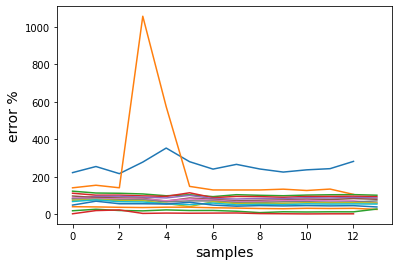

In [17]:
vertical_error_df = pd.DataFrame.from_dict(new_columns, orient='index')
errors_df = vertical_error_df.T

fig = plt.figure()
plt.plot(errors_df)
plt.xlabel('samples', fontsize=14)
plt.ylabel('error %', fontsize=14)

display(errors_df)
display(errors_df.describe())


In [24]:
adapted_power_df = total_df[['hour', 'weatherCode', 'active_power', 'p_mp']]
# display(plot_df.plot())
adapted_power_df['p_mp_adapted'] = adapted_power_df['p_mp'] * adapted_power_df['hour'].map(estimation_adaptations)
adapted_power_df['diff_adapted'] = adapted_power_df['p_mp_adapted'] - adapted_power_df['active_power']
adapted_power_df.head(50)

adapted_power_df.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
adapted_p_mp = adapted_power_df[['datetime', 'p_mp_adapted']]



In [26]:
adapted_p_mp

,datetime,p_mp_adapted
0,2021-06-01 05:00:00,1666.141
1,2021-06-01 06:00:00,1742.677
2,2021-06-01 07:00:00,2707.448
3,2021-06-01 08:00:00,3233.095
4,2021-06-01 09:00:00,3300.896
...,...,...
679,2021-06-30 12:00:00,2924.297
680,2021-06-30 13:00:00,2505.404
681,2021-06-30 14:00:00,1828.799
682,2021-06-30 15:00:00,1016.928


In [27]:
adapted_p_mp.to_csv("adapted_p_mp.csv")
!cp adapted_p_mp.csv "drive/My Drive/alexakos-thesis/datasets"

In [ ]:
filtered_power_df = total_filtered_power_df
filtered_power_df

,hour,active_power,p_mp,weatherCode,power_diff
datetime,,,,,
2021-06-01 05:00:00,5,1089.745,694.887,1101.000,-394.858
2021-06-01 06:00:00,6,2091.360,1642.146,1101.000,-449.214
2021-06-01 07:00:00,7,2893.392,2730.444,1100.000,-162.948
2021-06-01 08:00:00,8,3492.412,3604.646,1100.000,112.235
2021-06-01 09:00:00,9,3834.920,3997.659,1100.000,162.739
...,...,...,...,...,...
2021-06-30 12:00:00,12,2792.367,4553.179,1000.000,1760.812
2021-06-30 13:00:00,13,2335.633,4203.349,1001.000,1867.715
2021-06-30 14:00:00,14,1419.207,3535.648,1000.000,2116.441


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,101.248,84.718,116.169,103.036,102.525,112.951,127.850,119.158,142.173,132.824,135.580,131.000,97.225,90.619
1,89.996,75.859,103.454,99.924,109.270,102.598,109.304,118.225,136.783,141.931,127.312,94.557,75.925,46.028
2,91.368,65.567,114.218,97.861,105.006,104.689,106.401,105.257,115.557,109.018,101.112,102.348,77.537,56.466
3,120.772,68.946,103.177,102.812,98.320,101.696,106.202,106.915,111.750,108.177,98.801,98.335,83.371,66.458
4,127.268,73.301,100.981,100.412,106.885,101.960,92.641,111.290,114.849,119.440,114.151,90.813,90.090,103.630
5,87.731,55.169,92.578,115.015,98.542,86.175,87.788,110.066,117.035,108.990,102.673,103.774,80.601,21.418
6,58.486,67.867,101.793,82.389,120.388,79.196,86.948,47.701,81.611,82.764,89.082,99.870,87.171,67.716
7,88.749,111.139,113.187,109.434,100.351,103.163,106.692,106.628,111.823,103.652,93.832,211.018,340.132,236.543
8,99.946,60.846,73.954,94.097,97.626,122.371,118.798,26.739,7.575,9.320,47.538,105.642,105.369,37.142
9,103.908,54.381,117.581,120.098,103.312,105.593,109.692,130.013,110.332,164.952,140.692,117.891,137.795,84.720


,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,26.000,27.000,28.000,28.000,29.000,29.000,29.000,29.000,29.000,29.000,29.000,28.000,28.000,27.000
mean,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
std,16.791,105.113,9.607,9.473,7.867,9.729,14.033,21.628,25.850,27.892,28.074,30.303,54.395,77.514
min,58.486,54.381,73.954,82.389,87.177,79.196,54.233,26.739,7.575,9.320,44.088,43.193,47.274,21.418
25%,90.715,68.794,94.167,93.741,93.431,94.231,92.944,91.105,89.351,86.010,82.901,84.691,73.885,53.385
50%,98.718,70.794,99.865,98.767,99.156,101.960,105.237,105.263,110.332,103.652,98.801,96.938,88.630,68.577
75%,107.253,78.865,103.753,103.966,105.006,104.689,107.788,110.066,113.948,109.018,114.230,103.489,102.875,106.898
max,143.614,570.333,117.581,120.831,120.388,122.371,127.850,130.013,142.173,164.952,176.050,211.018,340.132,343.927


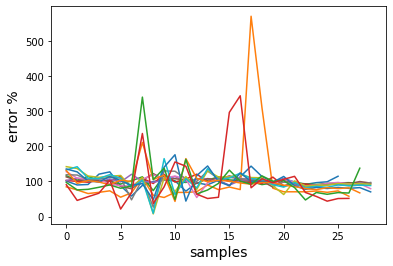

In [ ]:

new_columns = {}
for hour in range(4, 18):
    hour_df = adapted_power_df[adapted_power_df['hour'] == hour]
    hour_df['power_rate'] = hour_df['active_power'] / hour_df['p_mp_adapted']
    hour_df['power_rate_percentage'] = (hour_df['active_power'] / hour_df['p_mp_adapted']) * 100
    hour_df_selected = hour_df.reset_index()['power_rate_percentage'].values.tolist()
    new_columns[hour] = hour_df_selected
    #display(hour_df.describe())
vertical_error_df = pd.DataFrame.from_dict(new_columns, orient='index')
errors_df = vertical_error_df.T

fig = plt.figure()
plt.plot(errors_df)
plt.xlabel('samples', fontsize=14)
plt.ylabel('error %', fontsize=14)

display(errors_df)
display(errors_df.describe())
